# Satellite Image Analysis
Satellite Image Analysis refers to the process of extracting useful information and determining the features of an image obtained from a satellite. This type of analysis uses techniques that manipulate, interpret, and take advantage of the properties and characteristics of the data captured by the satellite, to make informed inferences and decisions. These manipulations essentially involve identifying and isolating specific elements within the image, measuring those elements, monitoring change over time, and more.


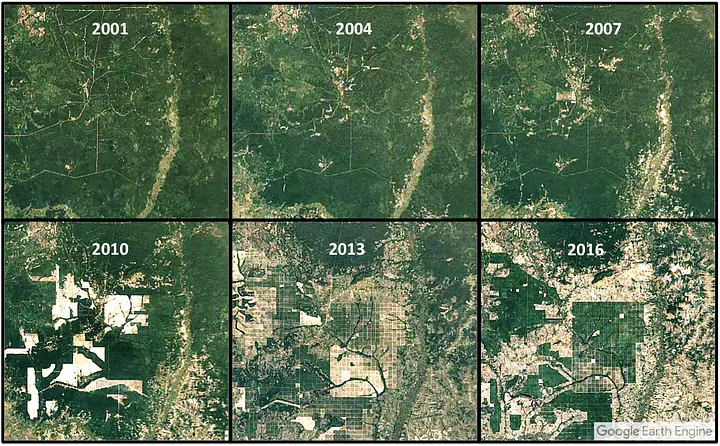



# How Satellite Data Is Used to Detect Deforestation
Satellite technology fulfills an important role in monitoring forests globally. Discover the opportunities, techniques, and challenges of detecting deforestation from space.

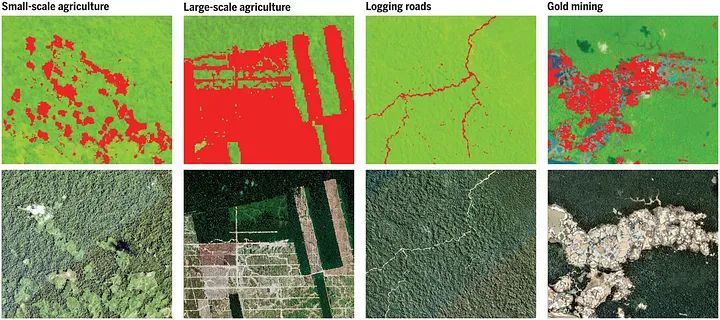

# Set API and Download the dataset

In [ ]:

# Authenticate Kaggle API (Upload kaggle.json manually or use existing token)
from google.colab import files
files.upload()  # Upload your kaggle.json file when prompted

# Move the Kaggle API key to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d nikitarom/planets-dataset

# Extract the dataset
import zipfile
import os

dataset_zip = "planets-dataset.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("planets_data")

# Check extracted files
os.listdir("planets_data")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nikitarom/planets-dataset
License(s): DbCL-1.0
 99% 1.49G/1.50G [00:14<00:00, 71.8MB/s]
100% 1.50G/1.50G [00:14<00:00, 108MB/s] 


['planet', 'test-jpg-additional']

# Preprocessing the Satellite Images code. This will:

 Load images from the extracted dataset.

 Convert object-type data to float32 (if necessary).

 Apply strong augmentations using Albumentations.

In [ ]:
import os

for root, dirs, files in os.walk("planets_data"):
    print(f"📂 {root}")
    for d in dirs:
        print(f"  📁 {d}")
    for f in files[:5]:  # Show only first 5 files per folder
        print(f"  📄 {f}")
    print("\n")


📂 planets_data
  📁 planet
  📁 test-jpg-additional


📂 planets_data/planet
  📁 planet


📂 planets_data/planet/planet
  📁 train-jpg
  📁 test-jpg
  📄 train_classes.csv
  📄 sample_submission.csv


📂 planets_data/planet/planet/train-jpg
  📄 train_13168.jpg
  📄 train_21209.jpg
  📄 train_19403.jpg
  📄 train_2026.jpg
  📄 train_14012.jpg


📂 planets_data/planet/planet/test-jpg
  📄 test_27326.jpg
  📄 test_40503.jpg
  📄 test_3104.jpg
  📄 test_5145.jpg
  📄 test_33591.jpg


📂 planets_data/test-jpg-additional
  📁 test-jpg-additional


📂 planets_data/test-jpg-additional/test-jpg-additional
  📄 file_8197.jpg
  📄 file_15466.jpg
  📄 file_10725.jpg
  📄 file_12610.jpg
  📄 file_15525.jpg




Total images found: 40479


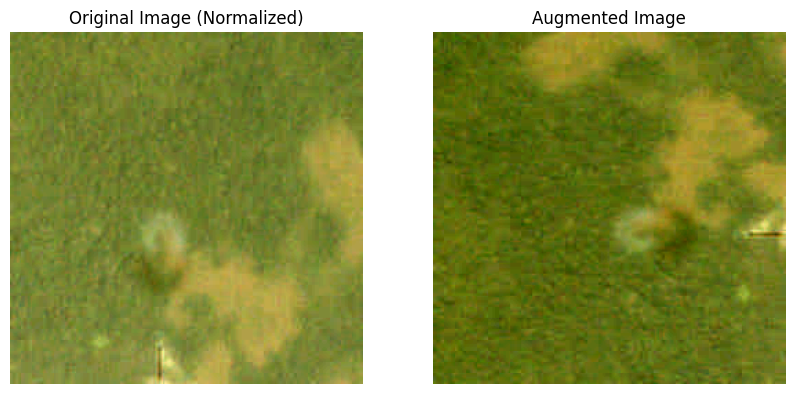

In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from glob import glob

# Define image directory (update if needed)
image_dir = "planets_data/planet/planet/train-jpg"  # Adjust path based on dataset structure

# Get list of image files
image_files = glob(os.path.join(image_dir, "*.jpg"))

# Check if images are loaded
print(f"Total images found: {len(image_files)}")

# Function to load an image and convert to float32
def load_image(image_path):
    img = cv2.imread(image_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img.astype(np.float32) / 255.0  # Normalize & convert to float32
    return img

# Function to normalize image contrast
def normalize_image(img):
    min_val = img.min()
    max_val = img.max()
    img = (img - min_val) / (max_val - min_val)  # Normalize to [0,1]
    return img

# Load a sample image
sample_img = load_image(image_files[0])

# Apply Min-Max Normalization
sample_img = normalize_image(sample_img)

# Apply strong augmentations
augmentations = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
])

augmented = augmentations(image=sample_img)['image']

# Display original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_img)
ax[0].set_title("Original Image (Normalized)")
ax[0].axis("off")

ax[1].imshow(augmented)
ax[1].set_title("Augmented Image")
ax[1].axis("off")

plt.show()


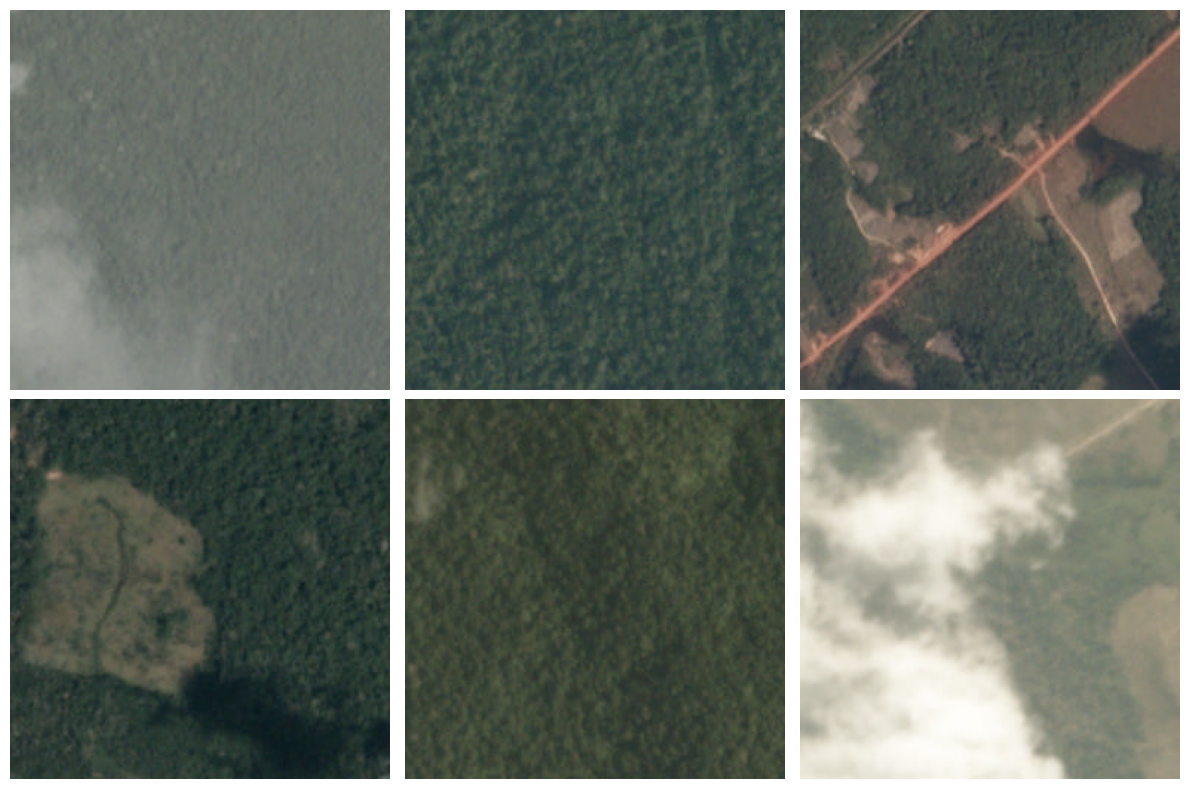

In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define dataset directory
dataset_dir = "planets_data/planet/planet/train-jpg"

# Load label file
labels_df = pd.read_csv("planets_data/planet/planet/train_classes.csv")

# Add image path to DataFrame
labels_df['image_path'] = labels_df['image_name'].apply(lambda x: os.path.join(dataset_dir, x + ".jpg"))

# Convert labels to one-hot encoding (assuming multi-label classification)
all_labels = labels_df.columns[1:-1].tolist()  # Exclude 'image_name' and 'image_path'
labels_df['encoded_labels'] = labels_df[all_labels].values.tolist()

# Store in train_df
train_df = labels_df[['image_path', 'encoded_labels']]

# Function to decode one-hot encoding back to text labels
def decode_labels(encoded_array):
    return [all_labels[i] for i, val in enumerate(encoded_array) if val == 1]

# Function to show random images with labels
def show_samples(df, num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    for ax in axes.flatten():
        idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[idx]['image_path']
        labels = decode_labels(df.iloc[idx]['encoded_labels'])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.set_title(", ".join(labels))
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
show_samples(train_df)


  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road


<ipython-input-3-1f538073fd1e>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


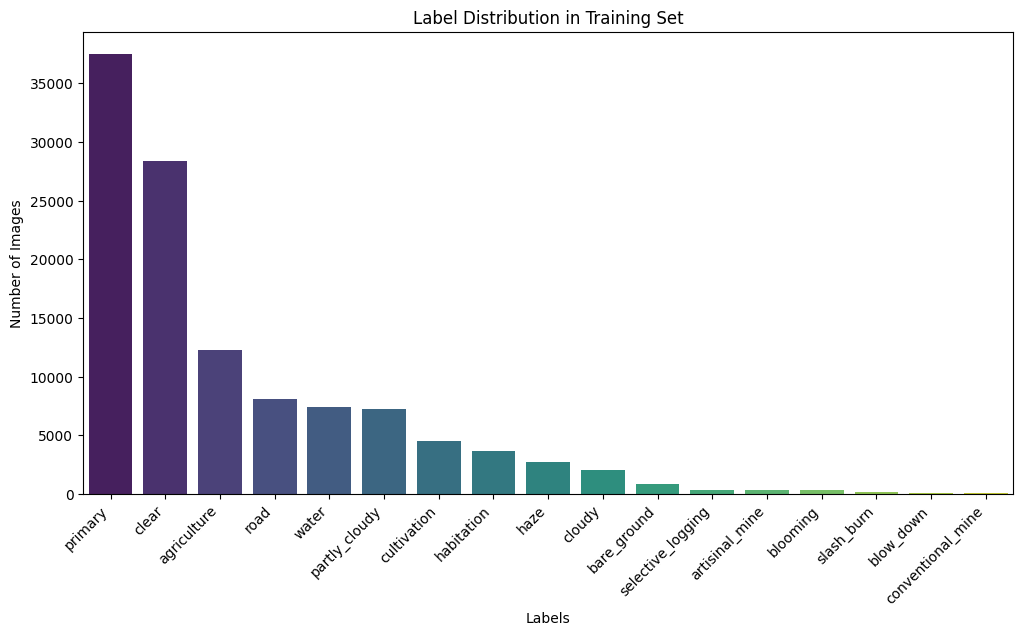

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV (Make sure the path is correct)
csv_path = "planets_data/planet/planet/train_classes.csv"
train_df = pd.read_csv(csv_path)

# Check the first few rows
print(train_df.head())

# Convert multi-labels to one-hot encoding (if not already done)
# Example format: "clear primary" -> ['clear', 'primary']
train_df["labels"] = train_df["tags"].apply(lambda x: x.split())

# Flatten the list of labels for counting
all_labels_flat = [label for labels in train_df["labels"] for label in labels]

# Count occurrences
label_counts = pd.Series(all_labels_flat).value_counts()

# Plot the label distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Labels")
plt.ylabel("Number of Images")
plt.title("Label Distribution in Training Set")
plt.show()


# Create a Custom PyTorch Dataset
Since this is a multi-label classification problem, we need to:

Map labels to indices (Convert tags into a binary vector).

Load images from train-jpg/ and apply transformations.

Return an image tensor + its corresponding one-hot encoded labels.

In [ ]:
import pandas as pd

csv_path = "planets_data/planet/planet/train_classes.csv"
df = pd.read_csv(csv_path)
print(df.head())  # Show first 5 rows


  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road


In [ ]:
import torch
import pandas as pd
import os
from PIL import Image
from torchvision import transforms

# Define dataset path
DATASET_PATH = "planets_data/planet/planet/"
IMAGE_FOLDER = os.path.join(DATASET_PATH, "train-jpg")

# Load CSV
df = pd.read_csv(os.path.join(DATASET_PATH, "train_classes.csv"))

# Get unique labels
all_labels = sorted(set(" ".join(df["tags"]).split()))
label_to_idx = {label: i for i, label in enumerate(all_labels)}  # Label-to-index mapping

# Convert tags to multi-hot encoding
def encode_labels(tags):
    labels = tags.split()
    encoded = torch.zeros(len(all_labels), dtype=torch.float32)
    for label in labels:
        encoded[label_to_idx[label]] = 1
    return encoded

# Custom Dataset Class
class PlanetDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]["image_name"]
        img_path = os.path.join(self.image_folder, f"{img_name}.jpg")
        image = Image.open(img_path).convert("RGB")

        # Apply transforms if given
        if self.transform:
            image = self.transform(image)

        labels = encode_labels(self.dataframe.iloc[idx]["tags"])
        return image, labels

# Define transforms (Resize, Normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create dataset
dataset = PlanetDataset(df, IMAGE_FOLDER, transform=transform)

# Check a sample
image, label = dataset[0]
print(f"Image Shape: {image.shape}")
print(f"Labels: {label}")


Image Shape: torch.Size([3, 128, 128])
Labels: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])


# Visualize Some Samples
Now, let’s plot a few images with their decoded labels to verify correctness.

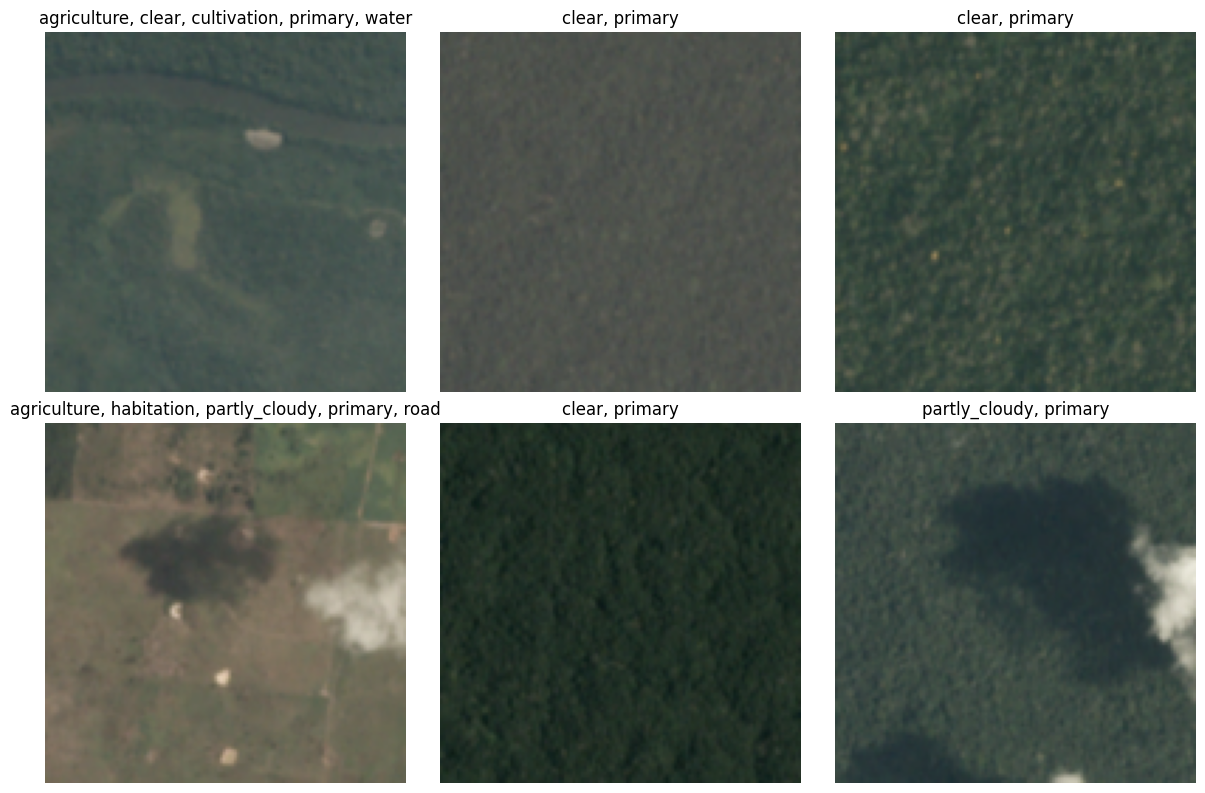

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Decode one-hot labels back to text
def decode_labels(encoded_labels):
    return [all_labels[i] for i, val in enumerate(encoded_labels) if val == 1]

# Show random images with labels
def show_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    for ax in axes.flatten():
        idx = np.random.randint(0, len(dataset))
        img, labels = dataset[idx]

        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy image
        img = (img * 0.5) + 0.5  # Reverse normalization

        label_text = ", ".join(decode_labels(labels))

        ax.imshow(img)
        ax.set_title(label_text)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
show_samples(dataset)


# Create DataLoaders
We’ll split the dataset into train and validation sets and create PyTorch DataLoader objects

In [ ]:
from torch.utils.data import DataLoader, random_split

# Define train-validation split (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")


Train Samples: 32383, Validation Samples: 8096


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define CNN architecture
class LandCoverCNN(nn.Module):
    def __init__(self, num_classes):
        super(LandCoverCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjust based on image size
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for multi-label classification
        return x

# Number of classes (adjust based on dataset)
num_classes = len(all_labels)

# Initialize model
model = LandCoverCNN(num_classes)
model.to(device)

print(model)


LandCoverCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=17, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate = 0.001

print("Optimizer and loss function defined! ✅")


Optimizer and loss function defined! ✅


In [ ]:
import torch
import torch.nn as nn

# ✅ Check if model is defined
if 'model' not in globals():
    print("Error: Model is not defined. Please initialize your model before training.")
else:
    print("Model Loaded ✅")

# Training parameters
num_epochs = 3  # Reduce epochs for testing
batch_size = 32  # Adjust based on available RAM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Check if DataLoader is working
try:
    sample_batch = next(iter(train_loader))
    print("DataLoader Working ✅ - Sample batch shape:", sample_batch[0].shape)
except Exception as e:
    print("Error: DataLoader is not working:", e)

# ✅ Check if optimizer & loss function are defined
if 'optimizer' not in globals() or 'criterion' not in globals():
    print("Error: Optimizer or Loss function is not defined.")
else:
    print("Optimizer & Loss Function Loaded ✅")

# Move model to device
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # ✅ Print batch loss every 100 batches to track progress
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # ✅ Print loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

print("Training complete! ✅")


Model Loaded ✅
Using device: cpu
DataLoader Working ✅ - Sample batch shape: torch.Size([32, 3, 128, 128])
Optimizer & Loss Function Loaded ✅
Epoch [1/3] - Batch 0/1012 - Loss: 0.6650
Epoch [1/3] - Batch 100/1012 - Loss: 0.6668
Epoch [1/3] - Batch 200/1012 - Loss: 0.6613
Epoch [1/3] - Batch 300/1012 - Loss: 0.6760
Epoch [1/3] - Batch 400/1012 - Loss: 0.6705
Epoch [1/3] - Batch 500/1012 - Loss: 0.6650
Epoch [1/3] - Batch 600/1012 - Loss: 0.6650
Epoch [1/3] - Batch 700/1012 - Loss: 0.6668
Epoch [1/3] - Batch 800/1012 - Loss: 0.6650
Epoch [1/3] - Batch 900/1012 - Loss: 0.6724
Epoch [1/3] - Batch 1000/1012 - Loss: 0.6797
Epoch [1/3] - Train Loss: 0.6702, Val Loss: 0.6707
Epoch [2/3] - Batch 0/1012 - Loss: 0.6724
Epoch [2/3] - Batch 100/1012 - Loss: 0.6742
Epoch [2/3] - Batch 200/1012 - Loss: 0.6760
Epoch [2/3] - Batch 300/1012 - Loss: 0.6852
Epoch [2/3] - Batch 400/1012 - Loss: 0.6668
Epoch [2/3] - Batch 500/1012 - Loss: 0.6705
Epoch [2/3] - Batch 600/1012 - Loss: 0.6650
Epoch [2/3] - Batch

# Load Images for Change Detection

In [ ]:
import cv2
import os

# Define the correct paths
image1_path = "/content/planets_data/test-jpg-additional/test-jpg-additional/file_8197.jpg"
image2_path = "/content/planets_data/test-jpg-additional/test-jpg-additional/file_15466.jpg"

# Load images
img_t1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
img_t2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

# Check if images are loaded correctly
if img_t1 is None or img_t2 is None:
    print("Error: One or both images could not be loaded. Check file paths.")
else:
    print("Images loaded successfully!")


Images loaded successfully!


# Compute Absolute Difference

In [ ]:
# Compute absolute difference
diff = cv2.absdiff(img_t1, img_t2)

# Apply thresholding to highlight changes
_, change_map = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

# Save or display the result
cv2.imwrite("change_map.jpg", change_map)
print("Change detection map saved as 'change_map.jpg'!")


Change detection map saved as 'change_map.jpg'!


# Display the Change Map

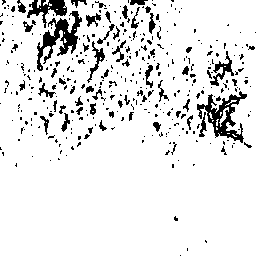

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(change_map)  # Display the change detection result


# Visualize environmental changes over time.

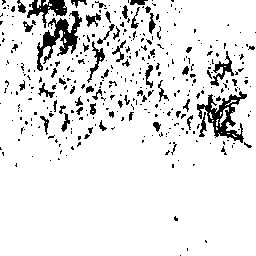

GIF saved as environmental_changes.gif


In [ ]:
import cv2
import imageio
import numpy as np
from google.colab.patches import cv2_imshow

# Define paths for two sequential images
image1_path = "/content/planets_data/test-jpg-additional/test-jpg-additional/file_8197.jpg"
image2_path = "/content/planets_data/test-jpg-additional/test-jpg-additional/file_15466.jpg"

# Load images
image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# Check if images were loaded successfully
if image1 is None or image2 is None:
    raise ValueError("One or both images could not be loaded. Check file paths.")

# Convert images to grayscale for change detection
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Compute absolute difference to detect changes
change_map = cv2.absdiff(gray1, gray2)

# Apply threshold to highlight significant changes
_, change_map = cv2.threshold(change_map, 30, 255, cv2.THRESH_BINARY)

# Display the change map
cv2_imshow(change_map)

# Save images as GIF
gif_filename = "environmental_changes.gif"
imageio.mimsave(gif_filename, [image1, image2], duration=1)
print(f"GIF saved as {gif_filename}")
